In [9]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy.stats import ranksums

import glob
import os
import matplotlib.pyplot as plt

from modules.utilities import *
from modules.constants import *
from modules import CliffsDelta
from scipy.stats import shapiro
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

plt.rcParams.update(mpl_params)
pio.templates.default = "custom_matplotlib_like"

TOPIC_DIR = "./Outputs/BERTopic/Topics"
DATA_DIR = "./Outputs/PerformancePRs"

In [10]:
type_df = read_aidev(FileName.POP_PR_TASK_TYPE)
perf_df = pd.read_csv(os.path.join(DATA_DIR, "POP_PULL_Requests_LLM_filtered_final.csv"))

In [11]:
topics = {}
for topic_file in glob.glob(os.path.join(TOPIC_DIR, "*.csv")):
    if "-1" not in topic_file:
        topic_name = os.path.basename(topic_file).replace(".csv", "")
        df = pd.read_csv(topic_file)
        topics[topic_name] = df

In [12]:
category_dfs = {}
for category, topic_list in category_map.items():
    dfs_to_concat = []
    for topic in topic_list:
        df = topics[topic].copy()
        df['topic_name'] = topic_map.get(topic, topic)
        df['category'] = category
        dfs_to_concat.append(df)
    
    if dfs_to_concat:
        category_dfs[category] = pd.concat(dfs_to_concat, ignore_index=True)

total = 0
for category, df in category_dfs.items():
    total += len(df)
    print(f"{category}: {len(df)} PRs")
print(f"Total PRs across all categories: {total}")

Development: 222 PRs
Low-level: 257 PRs
UI: 136 PRs
Caching: 87 PRs
Algorithmic: 119 PRs
Query: 61 PRs
Networking: 96 PRs
Analytics: 61 PRs
Hardware: 49 PRs
AI: 32 PRs
Total PRs across all categories: 1120


In [19]:
all_categories_df = pd.concat(category_dfs.values(), ignore_index=True)

In [20]:
# Merge task type information from type_df to perf_df based on pr id
all_categories_df = all_categories_df.merge(type_df[['id', 'type']], left_on='id', right_on='id', how='left')
all_categories_df


,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,Topic,Probability,Representative_document,topic_name,category,type
0,2912546402,448,Add GitHub API caching to prevent rate limiting,- Create GitHub API caching script that handle...,Claude_Code,1021104,8enmann,closed,2025-03-12T03:51:34Z,2025-05-06T17:50:00Z,NaN,937253475,https://api.github.com/repos/anthropics/claude...,https://github.com/anthropics/claude-code/pull...,0,1.0,False,CI/CD,Development,feat
1,3216159293,110,Add vcpkg dependency caching to Windows CI wor...,## Overview\n\nThis PR implements vcpkg depend...,Copilot,198982749,Copilot,closed,2025-07-09T14:30:39Z,2025-07-09T16:47:00Z,2025-07-09T16:47:00Z,564439013,https://api.github.com/repos/pelicanmapping/rocky,https://github.com/pelicanmapping/rocky/pull/110,0,1.0,False,CI/CD,Development,ci
2,3195588879,16531,Remove duplicate yarn eslint step from .circle...,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Copilot,198982749,Copilot,closed,2025-07-02T11:33:06Z,2025-07-02T12:24:50Z,2025-07-02T12:24:50Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16531,0,1.0,False,CI/CD,Development,ci
3,3074681764,13829,Update build documentation with quick build op...,This PR updates the build documentation (`tool...,Copilot,198982749,Copilot,open,2025-05-19T18:25:04Z,NaN,NaN,281765424,https://api.github.com/repos/microsoft/azurelinux,https://github.com/microsoft/azurelinux/pull/1...,0,1.0,False,CI/CD,Development,docs
4,3159826481,184,[WIP] Support .coshrc compilation,Thanks for assigning this issue to me. I'm sta...,Copilot,198982749,Copilot,closed,2025-06-19T10:34:39Z,2025-06-26T11:59:32Z,NaN,445862991,https://api.github.com/repos/tomhrr/cosh,https://github.com/tomhrr/cosh/pull/184,0,1.0,False,CI/CD,Development,feat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,3144466175,4,Implement local storage persistence,"A new persistence utility, `src/lib/persistenc...",Cursor,56125930,f1shy-dev,closed,2025-06-13T18:49:45Z,2025-06-13T18:49:52Z,2025-06-13T18:49:52Z,998301272,https://api.github.com/repos/intern3-chat/inte...,https://github.com/intern3-chat/intern3-chat/p...,48,1.0,False,Chat System,AI,feat
1116,3275952470,2777,fix: update schemaDesignTool to directly updat...,## Issue\n\n- resolve: Root cause issue where ...,Devin,158243242,devin-ai-integration[bot],open,2025-07-30T07:15:24Z,NaN,NaN,839216423,https://api.github.com/repos/liam-hq/liam,https://github.com/liam-hq/liam/pull/2777,48,1.0,True,Chat System,AI,fix
1117,3074294403,320,Integrate chatAudioIO module,# Integrate chatAudioIO module\n\nThis PR inte...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-19T15:42:40Z,2025-05-28T14:33:26Z,NaN,374381865,https://api.github.com/repos/stack-chan/stack-...,https://github.com/stack-chan/stack-chan/pull/320,48,1.0,False,Chat System,AI,feat
1118,3058809612,1399,Fix: Cache system info to prevent re-fetching ...,# Cache System Info to Prevent Re-fetching on ...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-13T05:33:38Z,2025-05-13T07:32:44Z,NaN,575321313,https://api.github.com/repos/langbot-app/LangBot,https://github.com/langbot-app/LangBot/pull/1399,48,1.0,False,Chat System,AI,fix


In [21]:
all_categories_df = all_categories_df[all_categories_df['type'] != 'perf']
all_categories_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,Topic,Probability,Representative_document,topic_name,category,type
0,2912546402,448,Add GitHub API caching to prevent rate limiting,- Create GitHub API caching script that handle...,Claude_Code,1021104,8enmann,closed,2025-03-12T03:51:34Z,2025-05-06T17:50:00Z,NaN,937253475,https://api.github.com/repos/anthropics/claude...,https://github.com/anthropics/claude-code/pull...,0,1.0,False,CI/CD,Development,feat
1,3216159293,110,Add vcpkg dependency caching to Windows CI wor...,## Overview\n\nThis PR implements vcpkg depend...,Copilot,198982749,Copilot,closed,2025-07-09T14:30:39Z,2025-07-09T16:47:00Z,2025-07-09T16:47:00Z,564439013,https://api.github.com/repos/pelicanmapping/rocky,https://github.com/pelicanmapping/rocky/pull/110,0,1.0,False,CI/CD,Development,ci
2,3195588879,16531,Remove duplicate yarn eslint step from .circle...,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Copilot,198982749,Copilot,closed,2025-07-02T11:33:06Z,2025-07-02T12:24:50Z,2025-07-02T12:24:50Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16531,0,1.0,False,CI/CD,Development,ci
3,3074681764,13829,Update build documentation with quick build op...,This PR updates the build documentation (`tool...,Copilot,198982749,Copilot,open,2025-05-19T18:25:04Z,NaN,NaN,281765424,https://api.github.com/repos/microsoft/azurelinux,https://github.com/microsoft/azurelinux/pull/1...,0,1.0,False,CI/CD,Development,docs
4,3159826481,184,[WIP] Support .coshrc compilation,Thanks for assigning this issue to me. I'm sta...,Copilot,198982749,Copilot,closed,2025-06-19T10:34:39Z,2025-06-26T11:59:32Z,NaN,445862991,https://api.github.com/repos/tomhrr/cosh,https://github.com/tomhrr/cosh/pull/184,0,1.0,False,CI/CD,Development,feat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,3185789444,8605,feat(worker): Implement bulk event sending method,%23%23%23 What changed%3F Why was the change n...,Cursor,8872447,scopsy,closed,2025-06-29T05:51:20Z,2025-06-29T10:56:55Z,NaN,400215964,https://api.github.com/repos/novuhq/novu,https://github.com/novuhq/novu/pull/8605,48,1.0,False,Chat System,AI,feat
1115,3144466175,4,Implement local storage persistence,"A new persistence utility, `src/lib/persistenc...",Cursor,56125930,f1shy-dev,closed,2025-06-13T18:49:45Z,2025-06-13T18:49:52Z,2025-06-13T18:49:52Z,998301272,https://api.github.com/repos/intern3-chat/inte...,https://github.com/intern3-chat/intern3-chat/p...,48,1.0,False,Chat System,AI,feat
1116,3275952470,2777,fix: update schemaDesignTool to directly updat...,## Issue\n\n- resolve: Root cause issue where ...,Devin,158243242,devin-ai-integration[bot],open,2025-07-30T07:15:24Z,NaN,NaN,839216423,https://api.github.com/repos/liam-hq/liam,https://github.com/liam-hq/liam/pull/2777,48,1.0,True,Chat System,AI,fix
1117,3074294403,320,Integrate chatAudioIO module,# Integrate chatAudioIO module\n\nThis PR inte...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-19T15:42:40Z,2025-05-28T14:33:26Z,NaN,374381865,https://api.github.com/repos/stack-chan/stack-...,https://github.com/stack-chan/stack-chan/pull/320,48,1.0,False,Chat System,AI,feat


In [ ]:
fig = go.Figure()

i = 1
for agent in sorted(all_categories_df['agent'].unique()):
    sub = all_categories_df[all_categories_df["agent"] == agent]
    cat_groups = sub.groupby("type")['id'].nunique().reset_index(name="count").sort_values(by="type", ascending=True)
      
    categories = []
    counts = []

    for cat in sorted(all_categories_df['type'].unique()):
        if cat not in cat_groups['type'].values:
            categories.append(cat)
            counts.append(0)
        else:
            cat_count = cat_groups[cat_groups['type'] == cat]['count'].values[0]
            categories.append(cat)
            
            total = all_categories_df[all_categories_df["type"] == cat]['id'].nunique()
            counts.append(cat_count/total * 100)
        

    fig.add_trace(go.Scatterpolar(
        r=counts,
        theta=categories,
        fill='none',
        line=dict(
                color=COLOR_MAP[agent],
                width=3
            ),
        marker=dict(
            size=5,
            symbol=MARKER_MAP[agent],
        ),
        name=agent,
    ))

    i += 1



fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        )
    ),

    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.05,          # pulls legend closer to plot
        xanchor="center",
        x=0.5
    ),

    margin=dict(
        l=0,
        r=0,
        t=30,
        b=40              # just enough for legend
    ),

    showlegend=True
)

fig.show()

In [23]:
fig = go.Figure()

i = 1
for agent in sorted(all_categories_df['category'].unique()):
    sub = all_categories_df[all_categories_df["category"] == agent]
    cat_groups = sub.groupby("type")['id'].nunique().reset_index(name="count").sort_values(by="type", ascending=True)
      
    categories = []
    counts = []

    for cat in sorted(all_categories_df["type"].unique()):
        if cat not in cat_groups['type'].values:
            categories.append(cat)
            counts.append(0)
        else:
            cat_count = cat_groups[cat_groups['type'] == cat]['count'].values[0]
            categories.append(cat)
            
            total = all_categories_df[all_categories_df["type"] == cat]['id'].nunique()
            counts.append(cat_count/total * 100)
        

    fig.add_trace(go.Scatterpolar(
        r=counts,
        theta=categories,
        fill='none',
        line=dict(
                color=CATEGORY_COLOR_MAP[agent],
                width=3
            ),
        name=agent,
    ))

    i += 1



fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        )
    ),

    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.05,          # pulls legend closer to plot
        xanchor="center",
        x=0.5
    ),

    margin=dict(
        l=0,
        r=0,
        t=30,
        b=40              # just enough for legend
    ),

    showlegend=True
)

fig.show()

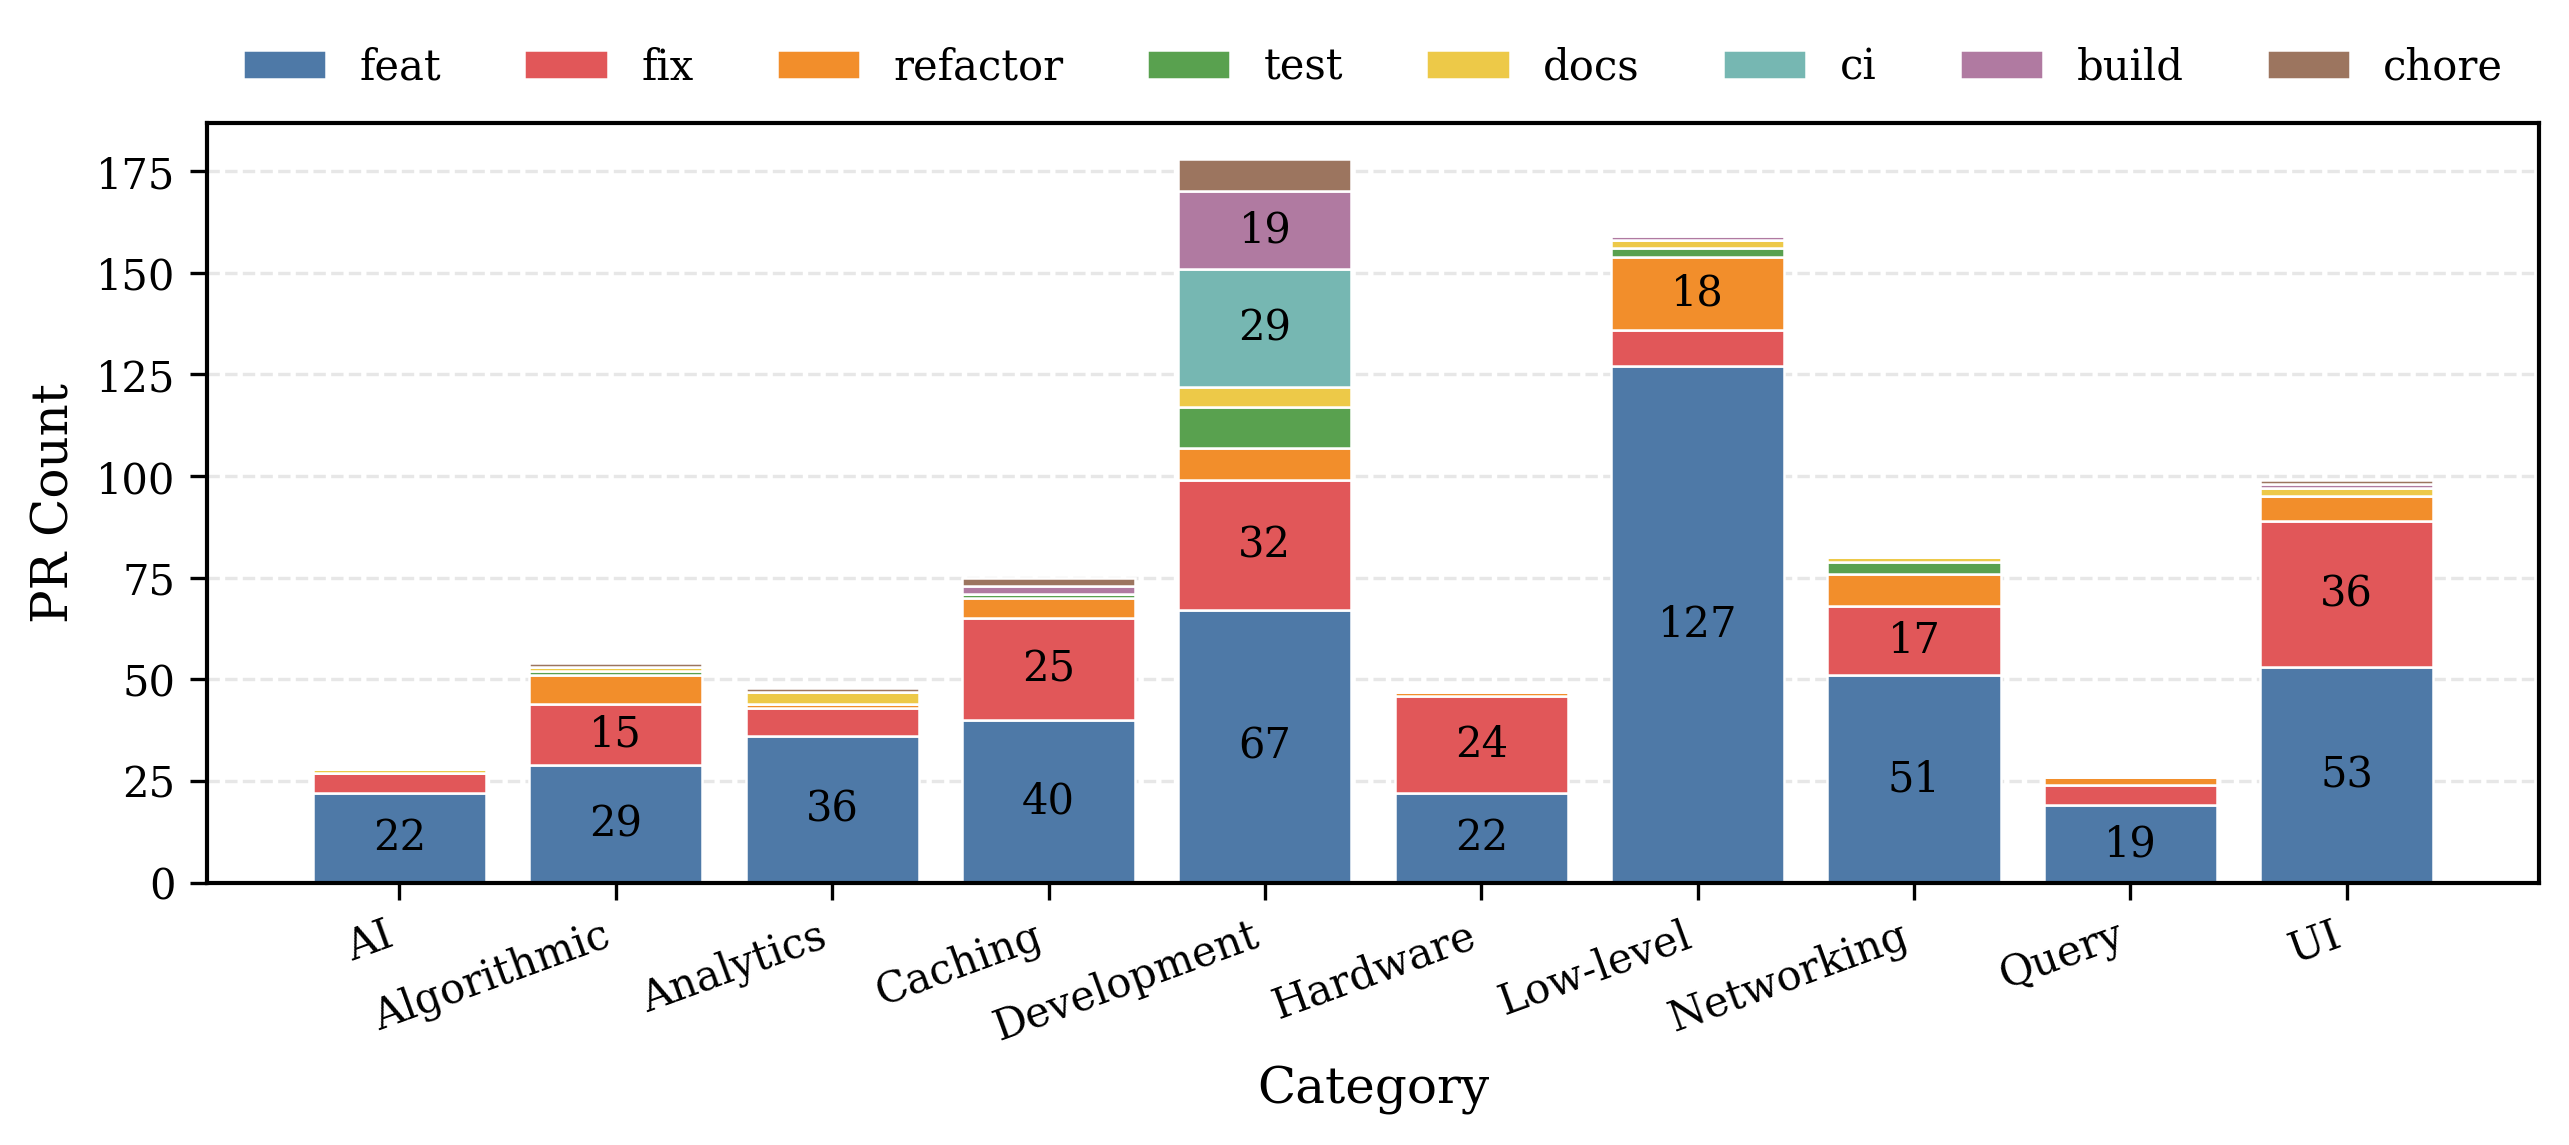

In [25]:
# Logical task order
TASK_ORDER = [
    "feat", "fix", "refactor",
    "test", "docs",
    "ci", "build", "chore"
]

# Color-blind safe palette
TASK_COLOR_MAP = {
    "feat":     "#4E79A7",
    "fix":      "#E15759",
    "refactor": "#F28E2B",
    "test":     "#59A14F",
    "docs":     "#EDC948",
    "ci":       "#76B7B2",
    "build":    "#B07AA1",
    "chore":    "#9C755F",
}

categories = sorted(all_categories_df["category"].unique())
x = np.arange(len(categories))

# Collect counts per task
counts_by_task = {}

for task in TASK_ORDER:
    counts = []
    for category in categories:
        sub = all_categories_df[
            (all_categories_df["category"] == category) &
            (all_categories_df["type"] == task)
        ]
        counts.append(sub["id"].nunique())
    counts_by_task[task] = np.array(counts)

# Plot
fig, ax = plt.subplots(figsize=(9, 4))

bottom = np.zeros(len(categories))

for task in TASK_ORDER:
    values = counts_by_task[task]

    bars = ax.bar(
        x,
        values,
        bottom=bottom,
        label=task,
        color=TASK_COLOR_MAP[task],
        edgecolor="white",
        linewidth=0.6
    )

    # Add value labels (only if meaningful)
    for i, val in enumerate(values):
        if val >= 15:
            ax.text(
                i,
                bottom[i] + val / 2,
                str(val),
                ha="center",
                va="center",
                fontsize=10
            )

    bottom += values


ax.set_xlabel("Category", fontsize=12)
ax.set_ylabel("PR Count", fontsize=12)

ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=20, ha="right")

ax.yaxis.grid(True, linestyle="--", alpha=0.3)
ax.set_axisbelow(True)

# Force legend order to match TASK_ORDER
handles, labels = ax.get_legend_handles_labels()

label_to_handle = dict(zip(labels, handles))

ordered_handles = [label_to_handle[task] for task in TASK_ORDER]
ordered_labels = TASK_ORDER

ax.legend(
    ordered_handles,
    ordered_labels,
    ncol=len(TASK_ORDER),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    frameon=False
)

plt.tight_layout()
plt.savefig("./Outputs/Figures/RQ5_PR_Tasks_per_Category_Breakdown.pdf", format="pdf", dpi=300)
plt.show()


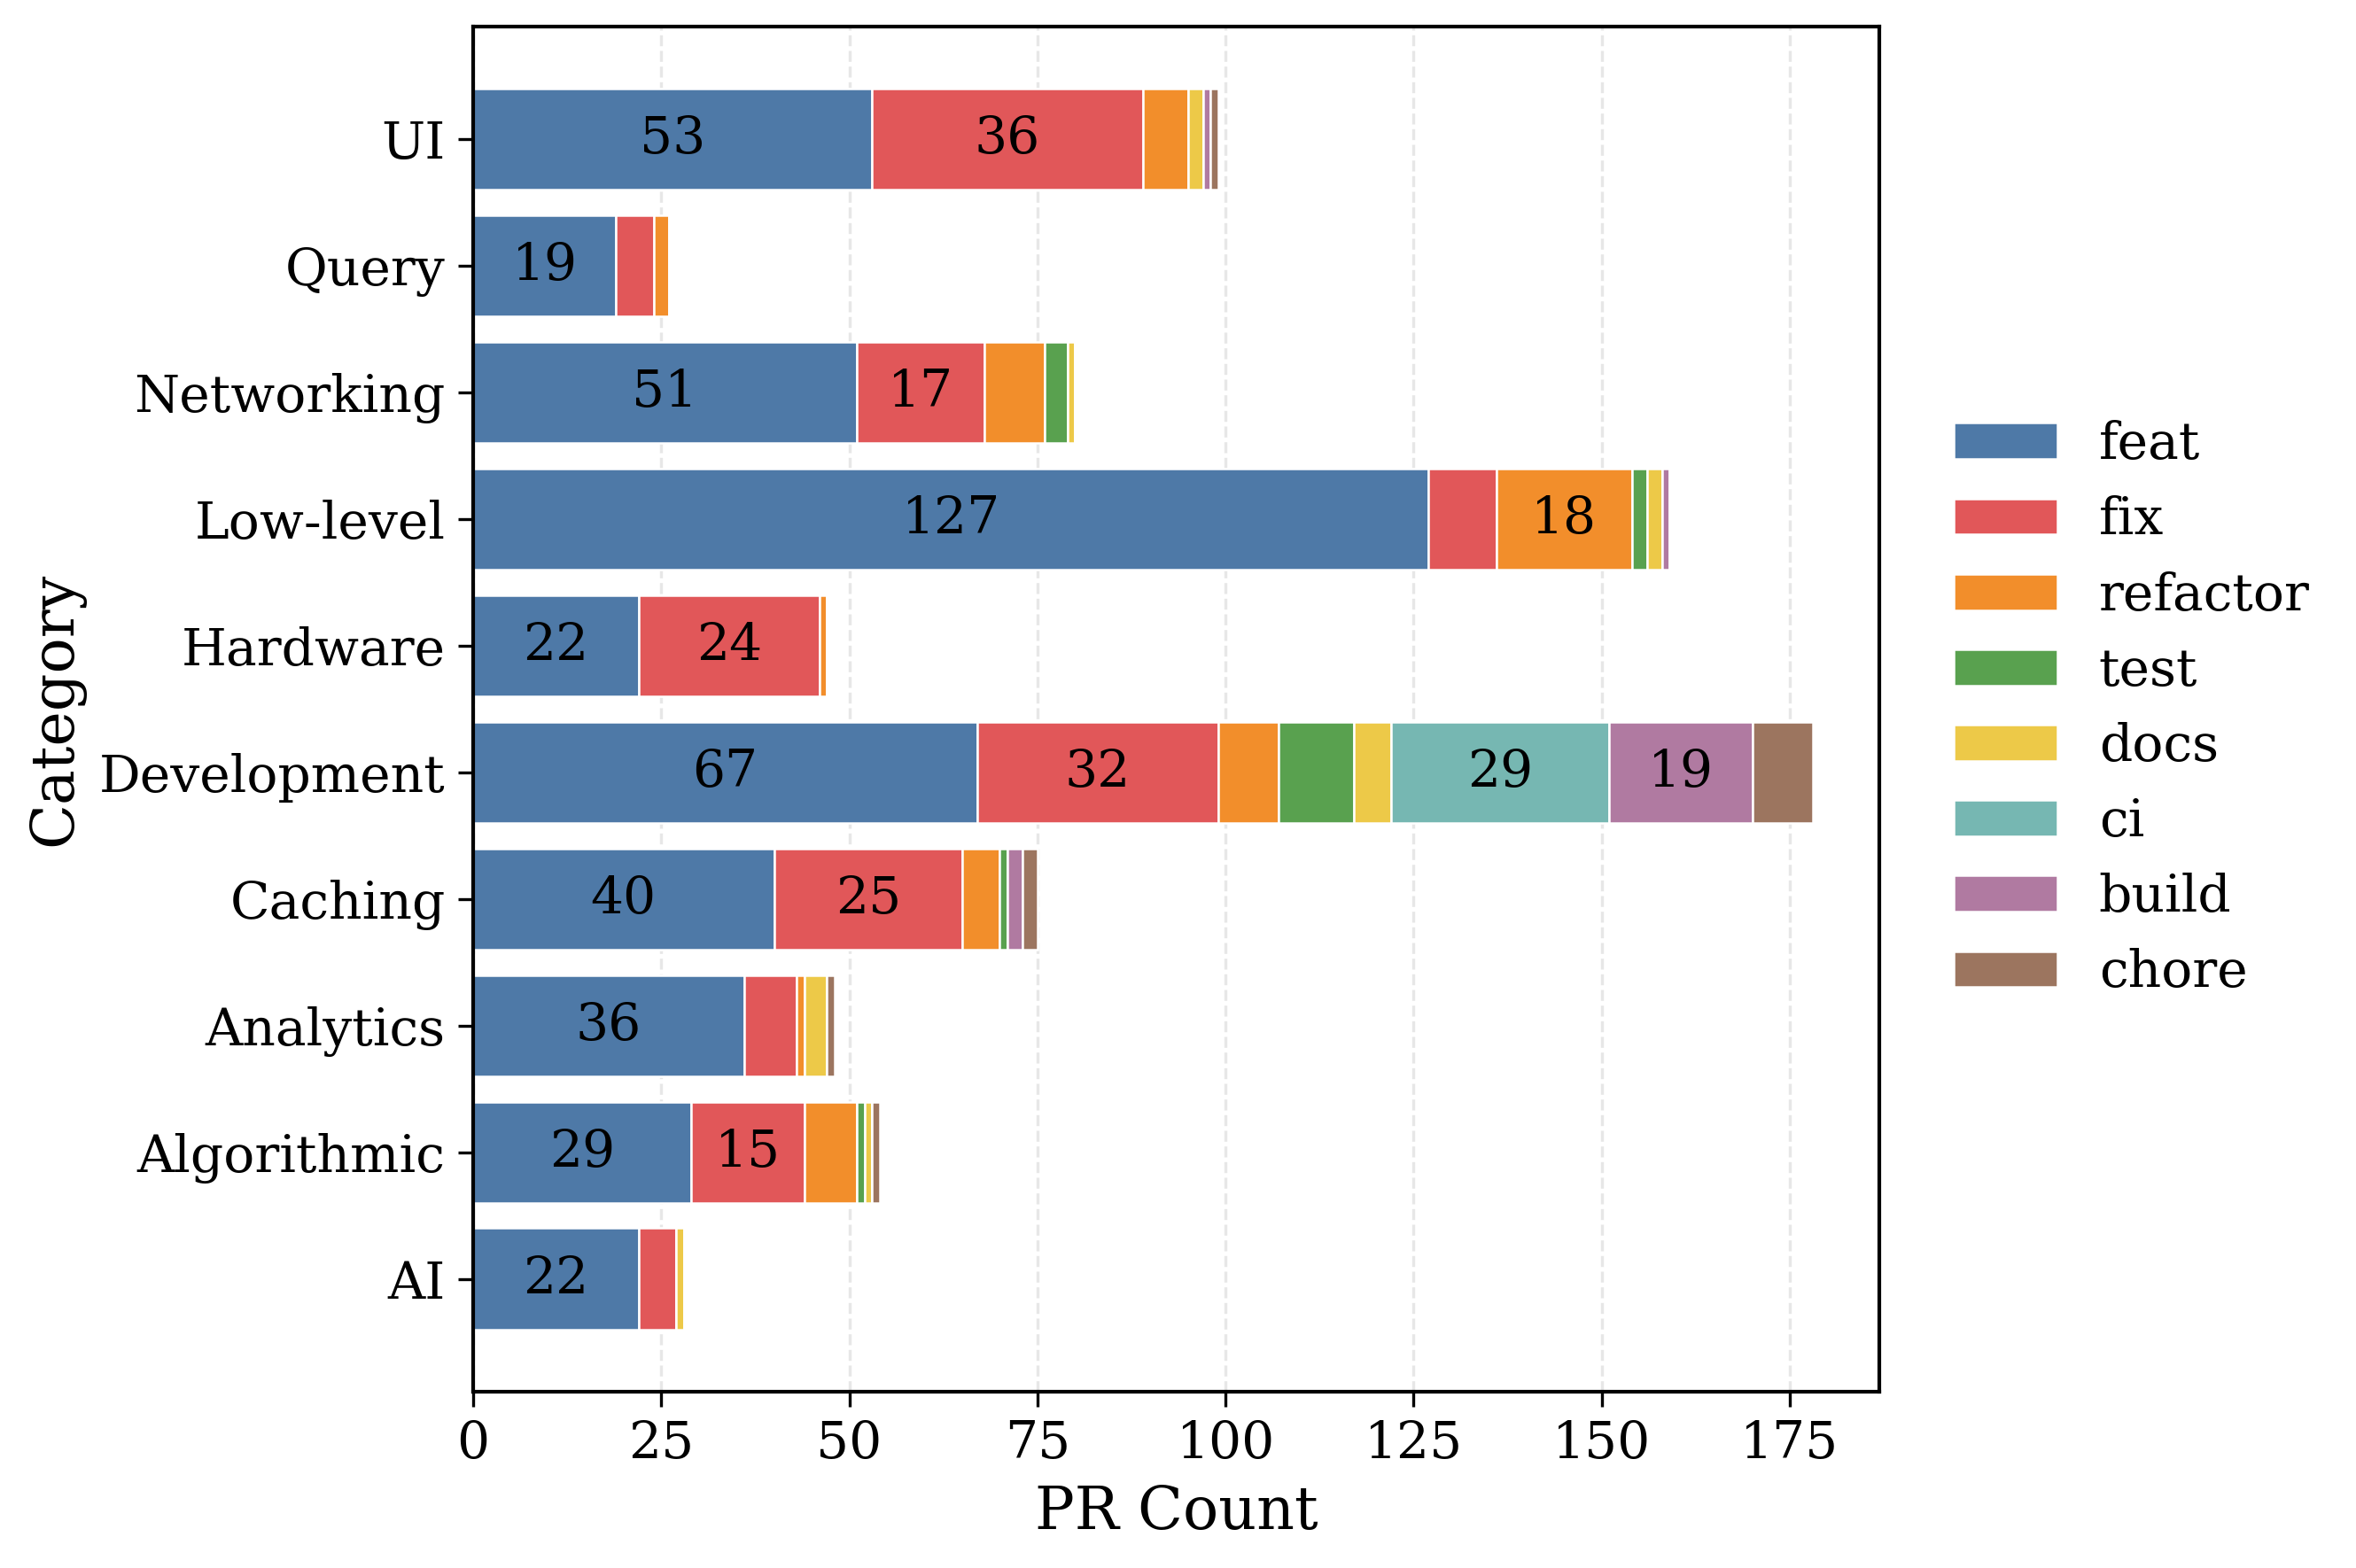

In [26]:
# Logical task order
TASK_ORDER = [
    "feat", "fix", "refactor",
    "test", "docs",
    "ci", "build", "chore"
]

# Color-blind safe palette
TASK_COLOR_MAP = {
    "feat":     "#4E79A7",
    "fix":      "#E15759",
    "refactor": "#F28E2B",
    "test":     "#59A14F",
    "docs":     "#EDC948",
    "ci":       "#76B7B2",
    "build":    "#B07AA1",
    "chore":    "#9C755F",
}

categories = sorted(all_categories_df["category"].unique())
y = np.arange(len(categories))

# Collect counts per task
counts_by_task = {}

for task in TASK_ORDER:
    counts = []
    for category in categories:
        sub = all_categories_df[
            (all_categories_df["category"] == category) &
            (all_categories_df["type"] == task)
        ]
        counts.append(sub["id"].nunique())
    counts_by_task[task] = np.array(counts)

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

left = np.zeros(len(categories))

for task in TASK_ORDER:
    values = counts_by_task[task]

    bars = ax.barh(
        y,
        values,
        left=left,
        label=task,
        color=TASK_COLOR_MAP[task],
        edgecolor="white",
        linewidth=0.6
    )

    # Add value labels (only if meaningful)
    for i, val in enumerate(values):
        if val >= 15:
            ax.text(
                left[i] + val / 2,
                i,
                str(val),
                ha="center",
                va="center",
                fontsize=14
            )

    left += values


ax.set_ylabel("Category", fontsize=16)
ax.set_xlabel("PR Count", fontsize=16)

ax.set_yticks(y)
ax.set_yticklabels(categories, fontsize=14)

ax.tick_params(axis='x', labelsize=14)

ax.xaxis.grid(True, linestyle="--", alpha=0.3)
ax.set_axisbelow(True)

# Force legend order to match TASK_ORDER
handles, labels = ax.get_legend_handles_labels()

label_to_handle = dict(zip(labels, handles))

ordered_handles = [label_to_handle[task] for task in TASK_ORDER]
ordered_labels = TASK_ORDER

ax.legend(
    ordered_handles,
    ordered_labels,
    ncol=1,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=14
)

plt.tight_layout()
plt.savefig("./Outputs/Figures/RQ5_PR_Tasks_per_Category_Breakdown.pdf", format="pdf", dpi=300)
plt.show()
